Setting up pyspark and other necssaary libraries.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq >/dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.1-bin-hadoop3'

In [ ]:
!pip install -q findspark
import findspark
findspark.init()
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col
from pyspark.sql.functions import isnan,when,count
from pyspark.sql import functions as F

import datetime
import numpy as np

import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Test 2 Spark") \
    .getOrCreate()

Reading the data.

In [ ]:
path = "data/amenity.csv"
amenity_log = spark.read.csv(path, header = True)

Understanding the data.

In [ ]:
amenity_log.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- amenity: string (nullable = true)
 |-- longitude-lattitude: string (nullable = true)
 |-- All_tags: string (nullable = true)



In [ ]:
amenity_log.describe().show()

+-------+-------------------+-----------------------------------+--------------------+--------------------+--------------------+
|summary|                _c0|                               name|             amenity| longitude-lattitude|            All_tags|
+-------+-------------------+-----------------------------------+--------------------+--------------------+--------------------+
|  count|             552667|                             468759|              552666|              415994|              552649|
|   mean|5.202562898620065E9|                           52367.59|                null|                null|                null|
| stddev|3.077197210317241E9|                 172929.17997147393|                null|                null|                null|
|    min|          100065924|                'amenity': 'coll...| 'addr:block': 'K...| 'addr:full': 'Dh...| 'addr:state': 'G...|
|    max|          arnataka'|ＶＧ ＫＵＬＫＡＲＩＮＩ ＨＯＳＰ...|        youth_centre|{'addr:full': 'SH...|{'zip

Adding a name to the unnamed column.

In [ ]:
amenity_log = amenity_log.withColumnRenamed("_c0", "id")

In [ ]:
amenity_log.show()

+---------+--------------------+----------------+--------------------+--------------------+
|       id|                name|         amenity| longitude-lattitude|            All_tags|
+---------+--------------------+----------------+--------------------+--------------------+
| 30612110|               Vaduj|            fuel|(74.4504660999997...|{'name': 'Vaduj',...|
| 46547616|     Tathgar Jathere|place_of_worship|(75.8640406999999...|{'name': 'Tathgar...|
| 53102901|Guru Nanak Dev Po...|         college|(75.8623133000000...|{'name': 'Guru Na...|
| 59710905|          SV medicos|        pharmacy|(75.8669552999998...|{'name': 'SV medi...|
| 59828202|        Arora Palace|          cinema|(75.8584576999998...|{'name': 'Arora P...|
| 59828488|          Auditorium|         theatre|(75.8607365999998...|{'name': 'Auditor...|
| 62069903|                Café|            cafe|(76.7266702999998...|{'name': 'Café', ...|
| 62070945|        Indra Danush|      restaurant|(77.1412912999998...|{'name': '

Total entries in the dataset.

In [ ]:
amenity_log.count()

311462

In [ ]:
amenity_log.distinct().count()

311462

How many null values in dataset.

In [ ]:
from pyspark.sql.functions import isnan,when,count

null_count = amenity_log.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in amenity_log.columns])

In [ ]:
null_count.show()

+---+-----+-------+-------------------+--------+
| id| name|amenity|longitude-lattitude|All_tags|
+---+-----+-------+-------------------+--------+
|  0|50136|      0|              68337|       6|
+---+-----+-------+-------------------+--------+



Dropping the null values in longitude-lattitude columns only.

---





No. of entries in longitude-lattitude column before dropping.

In [ ]:
amenity_log.select("longitude-lattitude").count()

311462

Dropping duplicates

In [ ]:
amenity_log_2 = amenity_log.na.drop(subset=["longitude-lattitude"])

In [ ]:
amenity_log_2.show()

No. of entries in longitude-lattitude column after dropping.

In [ ]:
amenity_log_2.select("longitude-lattitude").count()

243125

Checking for duplicates by checking co-ordinates.

---



In [ ]:
amenity_log_2.select("longitude-lattitude").count()

243125

In [ ]:
amenity_log_2.select("longitude-lattitude").distinct().count()

243091

Dropping locations with same
co-ordinates.

In [ ]:
amenity_log_3 = amenity_log_2.dropDuplicates(["longitude-lattitude"])

In [ ]:
amenity_log_3.show()

+----------+--------------------+----------------+--------------------+--------------------+
|        id|                name|         amenity| longitude-lattitude|            All_tags|
+----------+--------------------+----------------+--------------------+--------------------+
|1519893664|    Koteshwar Temple|place_of_worship|(68.5275501000000...|{'name': 'Koteshw...|
|1519894333|                null|place_of_worship|(68.5309378000000...|{'amenity': 'plac...|
|7935279881|Primary Health Ce...|        hospital|(68.5397127000001...|{'addr:full': 'Na...|
|7945342278|   Ashab Peer Dargah|place_of_worship|(68.6848668000001...|{'addr:full': 'Mo...|
|7945420148|  Buddha Wali Masjid|place_of_worship|(68.7137401000001...|{'addr:full': 'Ja...|
|7935279875|          DEV CLINIC|        hospital|(68.7501861000001...|{'addr:full': 'Pa...|
|7935279806|        Lakhpat Fort|        hospital|(68.7709818000001...|{'addr:full': 'Ko...|
|7945419559|Central Lampat Mo...|place_of_worship|(68.7738749000001...

In [ ]:
amenity_log_3.select("longitude-lattitude").count()

243091

Checking if ID has any duplicates.

In [ ]:
amenity_log_3.select("id").count()

243091

In [ ]:
amenity_log_3.select("id").distinct().count()

243091

Remove brackets from the longitude-lattitude column.

In [ ]:
amenity_log_4 = amenity_log_3.withColumn("longitude-lattitude", F.regexp_replace(F.regexp_replace(F.regexp_replace("longitude-lattitude", "\\)\\(", ""), "\\(", ""), "\\)", ""))

In [ ]:
amenity_log_4.show(truncate=False)

+----------+-------------------------------------+----------------+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id        |name                                 |amenity         |longitude-lattitude                  |All_tags                                                                                                                                                                                                                                    |
+----------+-------------------------------------+----------------+-------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Splitting Longitude and lattitude into 2 columns

In [ ]:
from pyspark.sql.functions import split

In [ ]:
new_amenity_log = amenity_log_4.withColumn('longitude', split(amenity_log_4['longitude-lattitude'], ',') .getItem(0)) \
                            .withColumn('lattitude', split(amenity_log_4['longitude-lattitude'], ',') .getItem(1))


In [ ]:
new_amenity_log.show()

+----------+--------------------+----------------+--------------------+--------------------+-----------------+-------------------+
|        id|                name|         amenity| longitude-lattitude|            All_tags|        longitude|          lattitude|
+----------+--------------------+----------------+--------------------+--------------------+-----------------+-------------------+
|1519893664|    Koteshwar Temple|place_of_worship|68.52755010000004...|{'name': 'Koteshw...|68.52755010000004| 23.687633699999953|
|1519894333|                null|place_of_worship|68.53093780000007...|{'amenity': 'plac...|68.53093780000007|  23.68305419999997|
|7935279881|Primary Health Ce...|        hospital|68.53971270000011...|{'addr:full': 'Na...|68.53971270000011| 23.676709899999988|
|7945342278|   Ashab Peer Dargah|place_of_worship|68.68486680000012...|{'addr:full': 'Mo...|68.68486680000012| 23.344217700000012|
|7945420148|  Buddha Wali Masjid|place_of_worship|68.71374010000015...|{'addr:full'

Drop the longitude-lattitude column.

In [ ]:
new_amenity_log = new_amenity_log.drop("longitude-lattitude")

In [ ]:
new_amenity_log.show()

+----------+--------------------+----------------+--------------------+-----------------+-------------------+
|        id|                name|         amenity|            All_tags|        longitude|          lattitude|
+----------+--------------------+----------------+--------------------+-----------------+-------------------+
|1519893664|    Koteshwar Temple|place_of_worship|{'name': 'Koteshw...|68.52755010000004| 23.687633699999953|
|1519894333|                null|place_of_worship|{'amenity': 'plac...|68.53093780000007|  23.68305419999997|
|7935279881|Primary Health Ce...|        hospital|{'addr:full': 'Na...|68.53971270000011| 23.676709899999988|
|7945342278|   Ashab Peer Dargah|place_of_worship|{'addr:full': 'Mo...|68.68486680000012| 23.344217700000012|
|7945420148|  Buddha Wali Masjid|place_of_worship|{'addr:full': 'Ja...|68.71374010000015| 23.219774900000026|
|7935279875|          DEV CLINIC|        hospital|{'addr:full': 'Pa...| 68.7501861000001|  23.68329419999999|
|793527980

SQL from here.

In [ ]:
new_amenity_log.createOrReplaceTempView("amenity_log_table")

In [ ]:
spark.sql("SELECT * FROM amenity_log_table LIMIT 5").show()

+----------+--------------------+----------------+--------------------+-----------------+-------------------+
|        id|                name|         amenity|            All_tags|        longitude|          lattitude|
+----------+--------------------+----------------+--------------------+-----------------+-------------------+
|1519893664|    Koteshwar Temple|place_of_worship|{'name': 'Koteshw...|68.52755010000004| 23.687633699999953|
|1519894333|                null|place_of_worship|{'amenity': 'plac...|68.53093780000007|  23.68305419999997|
|7935279881|Primary Health Ce...|        hospital|{'addr:full': 'Na...|68.53971270000011| 23.676709899999988|
|7945342278|   Ashab Peer Dargah|place_of_worship|{'addr:full': 'Mo...|68.68486680000012| 23.344217700000012|
|7945420148|  Buddha Wali Masjid|place_of_worship|{'addr:full': 'Ja...|68.71374010000015| 23.219774900000026|
+----------+--------------------+----------------+--------------------+-----------------+-------------------+



Distinct amenities.

In [ ]:
spark.sql('''
          SELECT COUNT(DISTINCT amenity) as amenities
          FROM amenity_log_table
          '''
          ).show()

+---------+
|amenities|
+---------+
|      365|
+---------+



In [ ]:
amenity = spark.sql('''
                    SELECT amenity
                    FROM amenity_log_table;
                    '''
                     )

In [ ]:
amenity.show()

+----------------+
|         amenity|
+----------------+
|place_of_worship|
|place_of_worship|
|        hospital|
|place_of_worship|
|place_of_worship|
|        hospital|
|        hospital|
|place_of_worship|
|        hospital|
|place_of_worship|
|place_of_worship|
|          clinic|
|         dentist|
|        hospital|
|        hospital|
|          clinic|
|          clinic|
|        hospital|
|place_of_worship|
|place_of_worship|
+----------------+
only showing top 20 rows



Convert to pandas in order to plot.

In [ ]:
amenity_pd = amenity.toPandas()

In [ ]:
amenities = amenity_pd['amenity'].value_counts()

In [ ]:
import seaborn as sns

Plot frequency.

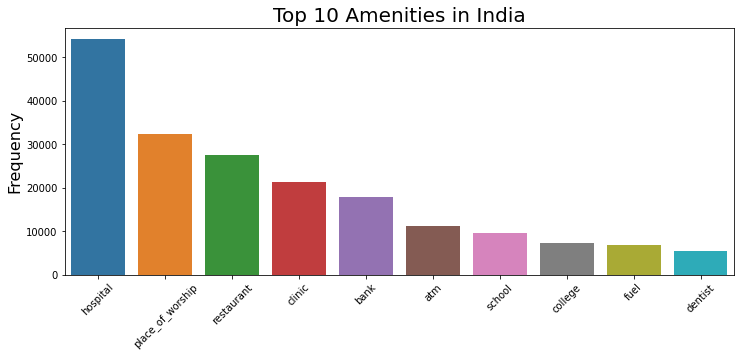

In [ ]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
g = sns.countplot(x='amenity',
                  data=amenity_pd[amenity_pd.amenity.isin(amenities[:10].index.values)],
                  order=amenities[:10].index.values,)
g.set_title("Top 10 Amenities in India", fontsize=20)
g.set_xlabel("", fontsize=16)
g.set_ylabel("Frequency", fontsize=16)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.show()

In [ ]:
schools = spark.sql('''
                        SELECT name, amenity, longitude, lattitude
                        FROM amenity_log_table
                        WHERE amenity = 'school';
                        '''
                        )

In [ ]:
school_pd = schools.toPandas()

In [ ]:
pip install geopandas

In [ ]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

Convert longitude and lattitude to float datatype.

In [ ]:
school_pd["longitude"] = school_pd["longitude"].astype(float)

In [ ]:
school_pd["lattitude"] = school_pd["lattitude"].astype(float)

Plot using geopandas

In [ ]:
geometry = [Point(xy) for xy in zip(school_pd['longitude'], school_pd['lattitude'])]
gdf = GeoDataFrame(school_pd, geometry = geometry)

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_geo(gdf,
                    lat=gdf.geometry.y,
                    lon=gdf.geometry.x,
                    hover_data=["name", "amenity"],
                    locationmode="country names"
                    )
fig.update_geos(fitbounds="locations")
fig.show()